In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
%matplotlib inline

# Load Images

Number of car images: 8792
Number of not-car images: 8968


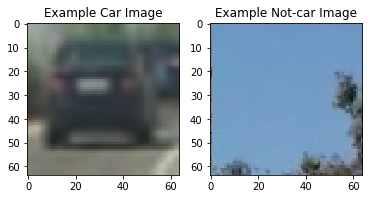

In [2]:
cars = glob.glob('training_images/vehicles/**/*.png')
notcars = glob.glob('training_images/non-vehicles/**/*.png')

car_image = mpimg.imread(cars[0])
notcar_image = mpimg.imread(notcars[0])

test_image = mpimg.imread('test_images/test6.jpg')

print('Number of car images:', len(cars))
print('Number of not-car images:', len(notcars))

fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [3]:
# Parameters
ystart = 400
ystop = 672
scale = 1.5
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
orient = 11
pix_per_cell = 16
cell_per_block = 2
# spatial_size = (32, 32) 
# hist_bins = 32    

# Get HOG Features

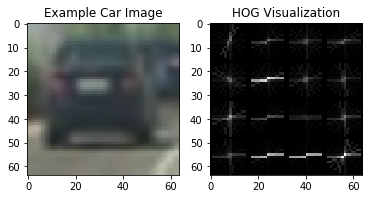

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=feature_vec)
        return features

gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# Extract Features

In [5]:
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image) 

#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         file_features.append(spatial_features)
        
#         hist_features = color_hist(feature_image, nbins=hist_bins)
#         file_features.append(hist_features)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, 
                                                     pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        file_features.append(hog_features)
        features.append(np.concatenate(file_features))

    return features

# Train Classifier

In [6]:
sample_size = 1200
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

car_features = extract_features(cars, cspace=color_space, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=color_space, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [7]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()

0.1 Seconds to train SVC...
Test Accuracy of SVC =  0.9979


In [8]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, orient, 
              pix_per_cell, cell_per_block, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
          
            test_prediction = svc.predict([hog_features])
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

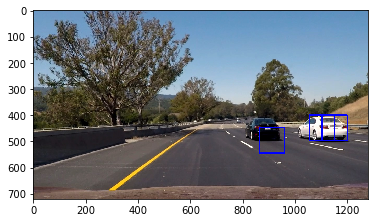

In [9]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=4):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

rectangles = find_cars(test_image, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                       hog_channel=hog_channel, svc=svc, orient=orient, 
                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False)

window_img = draw_boxes(test_image, rectangles, color=(0, 0, 255), thick=3) 

plt.imshow(window_img)

# Multi-scale Windows

Number of boxes:  8


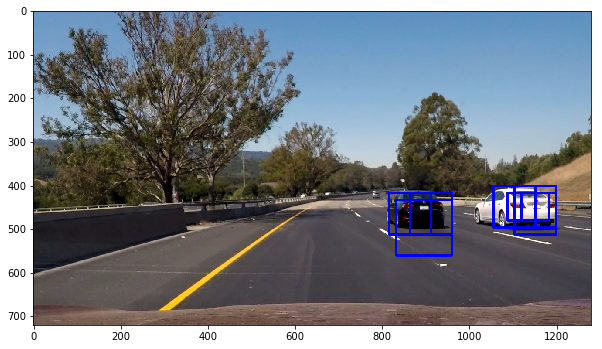

In [10]:
rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(test_image, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                       hog_channel=hog_channel, svc=svc, orient=orient, 
                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))
ystart = 416
ystop = 480
scale = 1.0
rects.append(find_cars(test_image, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                       hog_channel=hog_channel, svc=svc, orient=orient, 
                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))

ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(test_image, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                       hog_channel=hog_channel, svc=svc, orient=orient, 
                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))

ystart = 416
ystop = 536
scale = 1.5
rects.append(find_cars(test_image, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                       hog_channel=hog_channel, svc=svc, orient=orient, 
                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))

ystart = 440
ystop = 568
scale = 2.0
rects.append(find_cars(test_image, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                       hog_channel=hog_channel, svc=svc, orient=orient, 
                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))

ystart = 432
ystop = 560
scale = 2.0
rects.append(find_cars(test_image, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                       hog_channel=hog_channel, svc=svc, orient=orient, 
                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))

ystart = 472
ystop = 632
scale = 2.5
rects.append(find_cars(test_image, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                       hog_channel=hog_channel, svc=svc, orient=orient, 
                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))

ystart = 512
ystop = 672
scale = 2.5
rects.append(find_cars(test_image, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                       hog_channel=hog_channel, svc=svc, orient=orient, 
                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_image, rectangles, color=(0, 0, 255), thick=3)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

# Add Heat & Apply Threshold

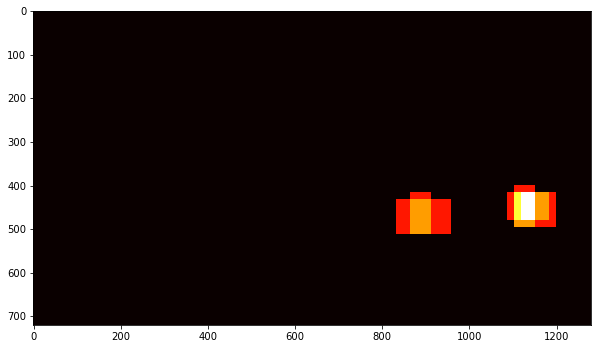

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

heatmap_img = np.zeros_like(test_image[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


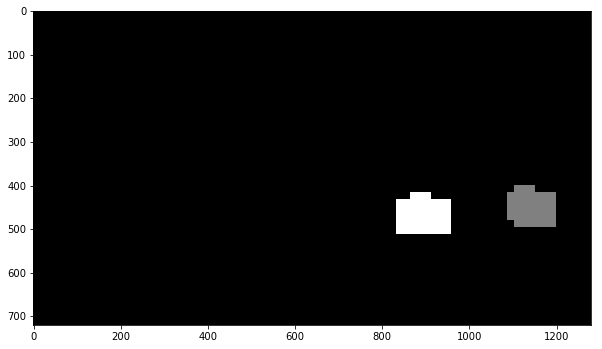

In [12]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

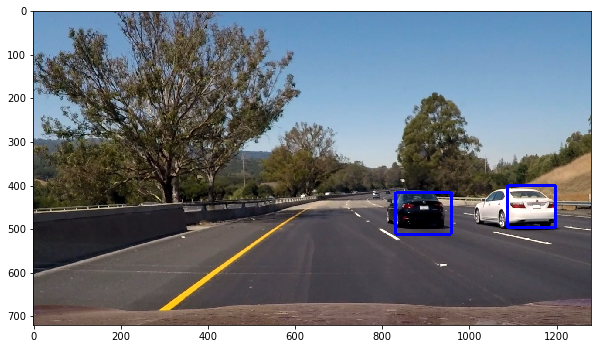

In [17]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_image), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [14]:
def process(img):
    rects = []
    
    color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2

    ystart = 400
    ystop = 464
    scale = 1.0
    rects.append(find_cars(img, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                           hog_channel=hog_channel, svc=svc, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))
    ystart = 416
    ystop = 480
    scale = 1.0
    rects.append(find_cars(img, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                           hog_channel=hog_channel, svc=svc, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))

    ystart = 400
    ystop = 496
    scale = 1.5
    rects.append(find_cars(img, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                           hog_channel=hog_channel, svc=svc, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))

    ystart = 416
    ystop = 536
    scale = 1.5
    rects.append(find_cars(img, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                           hog_channel=hog_channel, svc=svc, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))

    ystart = 440
    ystop = 568
    scale = 2.0
    rects.append(find_cars(img, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                           hog_channel=hog_channel, svc=svc, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))

    ystart = 432
    ystop = 560
    scale = 2.0
    rects.append(find_cars(img, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                           hog_channel=hog_channel, svc=svc, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))

    ystart = 472
    ystop = 632
    scale = 2.5
    rects.append(find_cars(img, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                           hog_channel=hog_channel, svc=svc, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))

    ystart = 512
    ystop = 672
    scale = 2.5
    rects.append(find_cars(img, ystart=ystart, ystop=ystop, scale=scale, cspace=color_space,
                           hog_channel=hog_channel, svc=svc, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, show_all_rectangles=False))

    rectangles = [item for sublist in rects for item in sublist]     
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test_output.mp4'
clip2 = VideoFileClip('test_video.mp4')
test_clip = clip2.fl_image(process)
%time test_clip.write_videofile(test_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|█████████▋| 38/39 [00:13<00:00,  2.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 11.1 s, sys: 2.03 s, total: 13.2 s
Wall time: 15.4 s


In [16]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process)
%time clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [08:00<00:00,  2.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 7s, sys: 1min 6s, total: 7min 14s
Wall time: 8min 2s
